# 0.0. IMPORTS

In [57]:
import pandas              as pd
import numpy               as np
import seaborn             as sb
import matplotlib.pyplot   as plt

import inflection
import math
import datetime

from IPython.display import Image

## 0.1. Support Functions

## 0.2. Loading Data

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. DATA DESCRIPTION

In [3]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [4]:
old_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

new_columns = list( map(snakecase, old_columns) )

#rename
df1.columns = new_columns

## 1.2. Data Dimensions

In [5]:
print( f'Number of rows: {df1.shape[0]}')
print( f'Number of columns: {df1.shape[1]}')

Number of rows: 1017209
Number of columns: 18


## 1.3. Data Types

In [6]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

Verifica quais colunas possuem dados faltantes. Este passo é necessário para realizar algum tipo de tratamento em cima destas colunas.

In [7]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. FIllout NA

Existem várias abordagens para realizar o preenchimento de valores faltantes, mas neste projeto utilizei o método de preenchimento pensando no negócio. Não tenho expertise na área de vendas, portanto, nem todas substituições poderão ser a mais adequada.

In [8]:
# competition_distance
max_distance_value = 200000.0
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: max_distance_value if math.isnan(x) else x)

# competition_open_since_month  
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year  
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week    
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [9]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [10]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistical

A descrição estatística é muito importante para ganhar conhecimento de negócio e conseguir identificar erros nos dados que estamos trabalhando.

In [11]:
# select numercial columns
num_attributes = df1.select_dtypes(include=['int64', 'float64', ])

# select categorical columns
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [12]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
metrics = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
metrics.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

In [13]:
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


## 1.7.2. Categorical Attributes

In [14]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

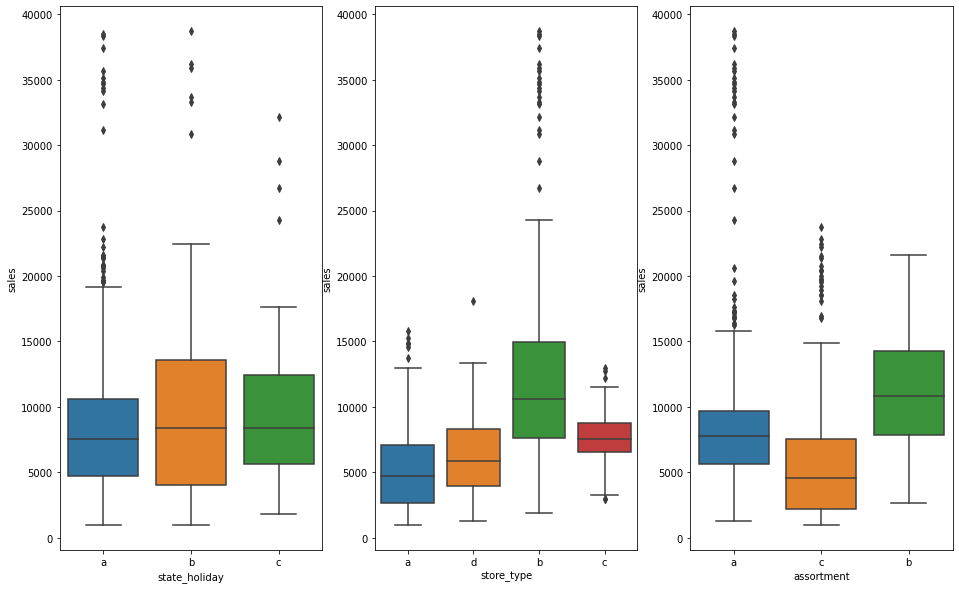

In [15]:
# filter only important datas
aux1 = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 )]

plt.figure( figsize=( 16, 10 ) )
plt.subplot( 1, 3, 1)
sb.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1, 3, 2)
sb.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot( 1, 3, 3)
sb.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0. FEATURE ENGINEERING

In [16]:
df2 = df1.copy()

## 2.1. Mind Map Hypothesis

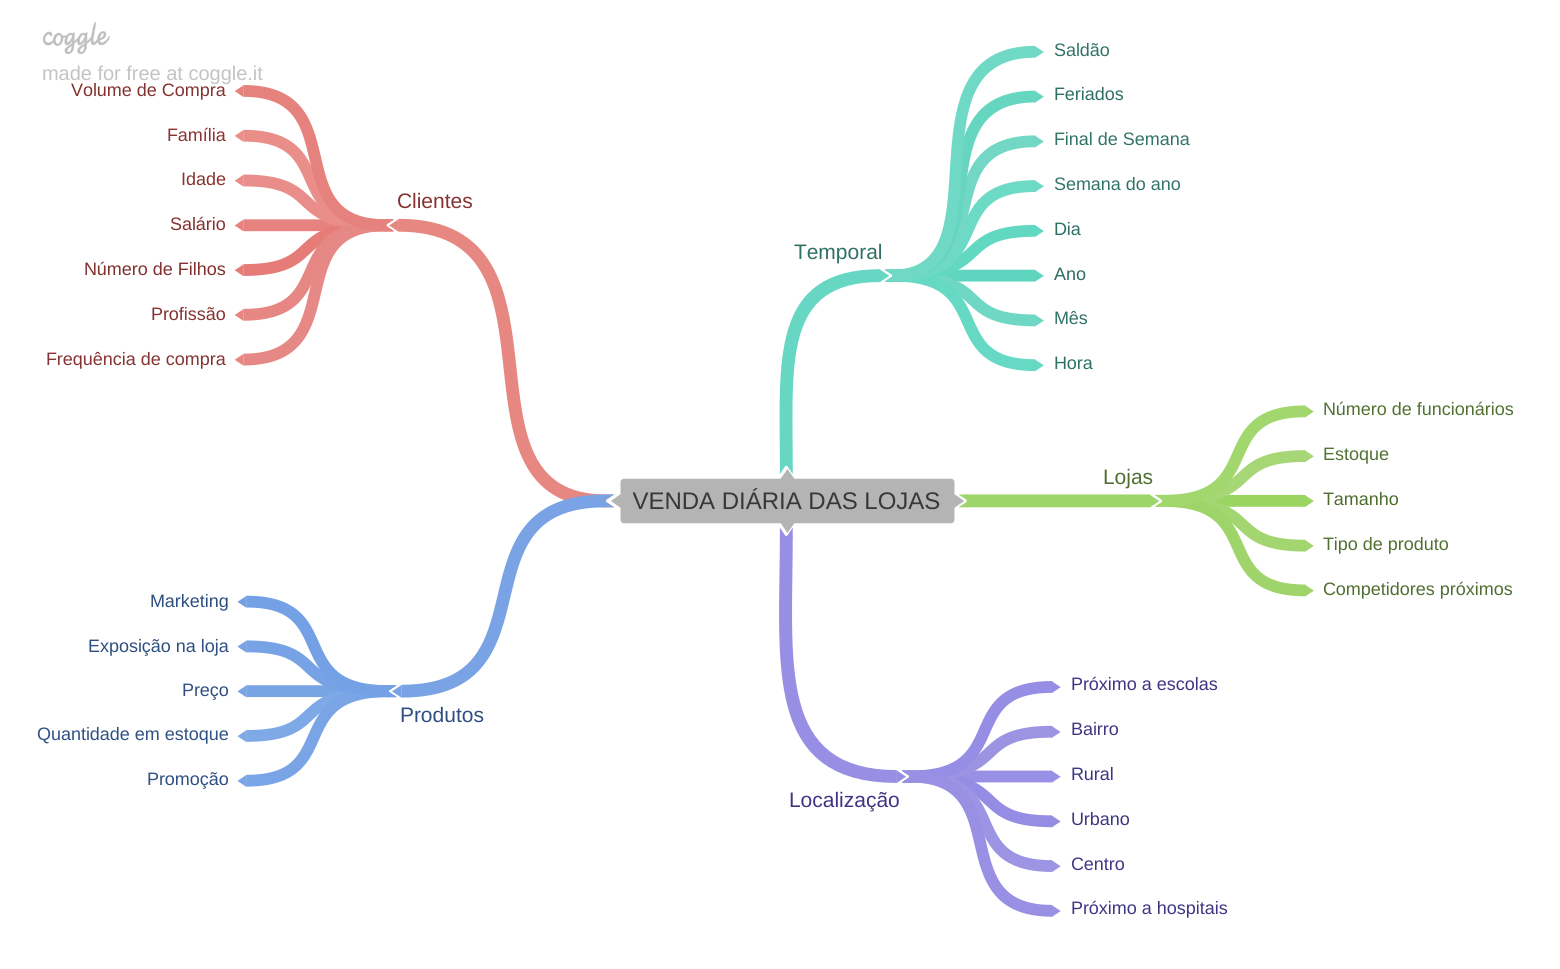

In [17]:
Image('img/mind_map_hypothesis.png')

### 2.1.1. Lojas Hypothesis

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento de produtos deveriam vender mais.

**6.** Lojas com competidores mais próximos deveriam vender menos.

**7.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.1.2. Produto Hypothesis

**8.** Lojas que investem mais em marketing deveriam vender mais.

**9.** Lojas que expõe mais o produtos nas vitrines deveriam vender mais.

**10.** Lojas que tem preço menores nos produtos deveriam vender mais.

**11.** Lojas que tem produtos com preço menores por mais tempo deveriam vender mais.

**12.** Lojas com promoções mais "agressivas" deveriam vender mais.

**13.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**14.** Lojas com mais dias de promoção deveriam vender mais.

**15.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Temporal Hypothesis

**16.** Lojas que abrem durante o feriado de Natal deveriam vender mais.

**17.** Lojas deveriam vender menos aos finais de semana.

**18.** Lojas deveriam vender mais ao longo dos anos.

**19.** Lojas deveriam vender mais no segundo semestre do ano.

**20.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**21.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2. Final Hypothesis List

Hipóteses que são possíveis de serem respondidas com base no conjunto de dados disponível. Em um ambiente real, as informações faltantes seriam solicitadas ao time de engenharia de dados para disponibilizarem algumas variáveis importantes para responder as demais hipóteses.

**5.** Lojas com maior sortimento de produtos deveriam vender mais.

**6.** Lojas com competidores mais próximos deveriam vender menos.

**7.** Lojas com competidores à mais tempo deveriam vender mais.

**13.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**14.** Lojas com mais dias de promoção deveriam vender mais.

**15.** Lojas com mais promoções consecutivas deveriam vender mais.

**16.** Lojas que abrem durante o feriado de Natal deveriam vender mais.

**17.** Lojas deveriam vender menos aos finais de semana.

**18.** Lojas deveriam vender mais ao longo dos anos.

**19.** Lojas deveriam vender mais no segundo semestre do ano.

**20.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**21.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [18]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1)
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/ 7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if  x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if  x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

<ipython-input-18-1aae8a21f697>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0. FILTERING VARIABLES

In [19]:
df3 = df2.copy()

## 3.1. Filtering Rows

In [20]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2 Columns Selection

In [21]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0. EXPLORATORY DATA ANALYSIS

In [22]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

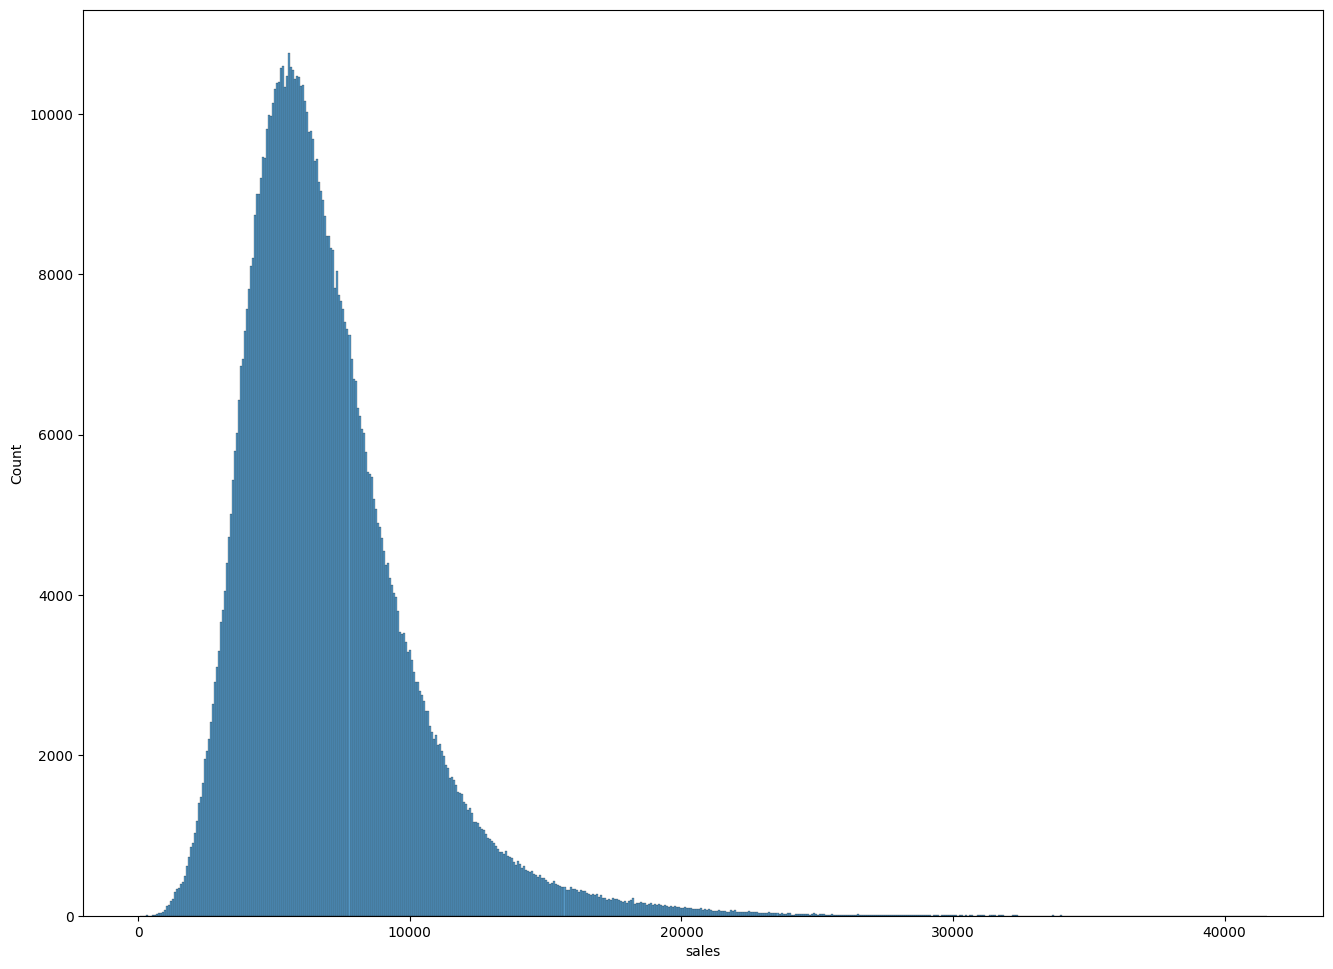

In [63]:
plt.rcParams['figure.figsize'] = [16, 12]
sb.histplot( df4['sales'] );

### 4.1.2. Numerical Variable

Analisando o gráfico abaixo das variáveis númericas, pode-se perceber que, a feature **day_of_week** não possui variações, ou seja, as lojas venderam basicamente a mesma quantidade durante cada dia da semana, portanto, esta feature não será relevante para o modelo. Outras features apresentaram informações importantes para o negócio, como a **is_promo** na qual, percebe-se que houve mais vendas de produtos que não estavam em promoção, o que pode ser um insight para o time de negócio.

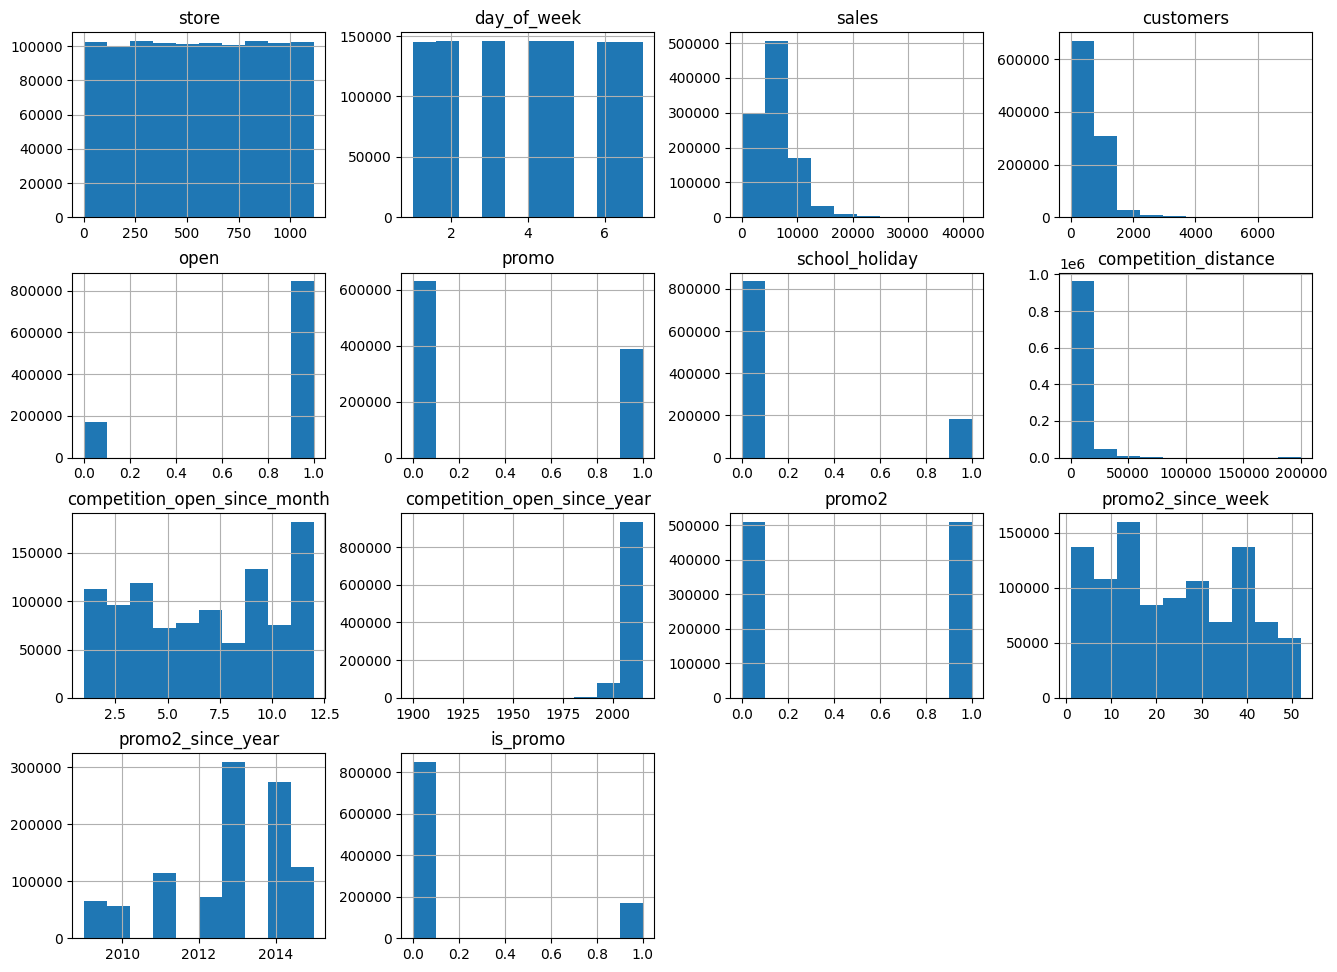

In [64]:
num_attributes.hist();

### 4.1.3. Categorical Variable

/home/ronaldo/Documentos/Projetos de Portifólio/Rossmann Sales Prediction/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ronaldo/Documentos/Projetos de Portifólio/Rossmann Sales Prediction/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ronaldo/Documentos/Projetos de Portifólio/Rossmann Sales Prediction/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only 

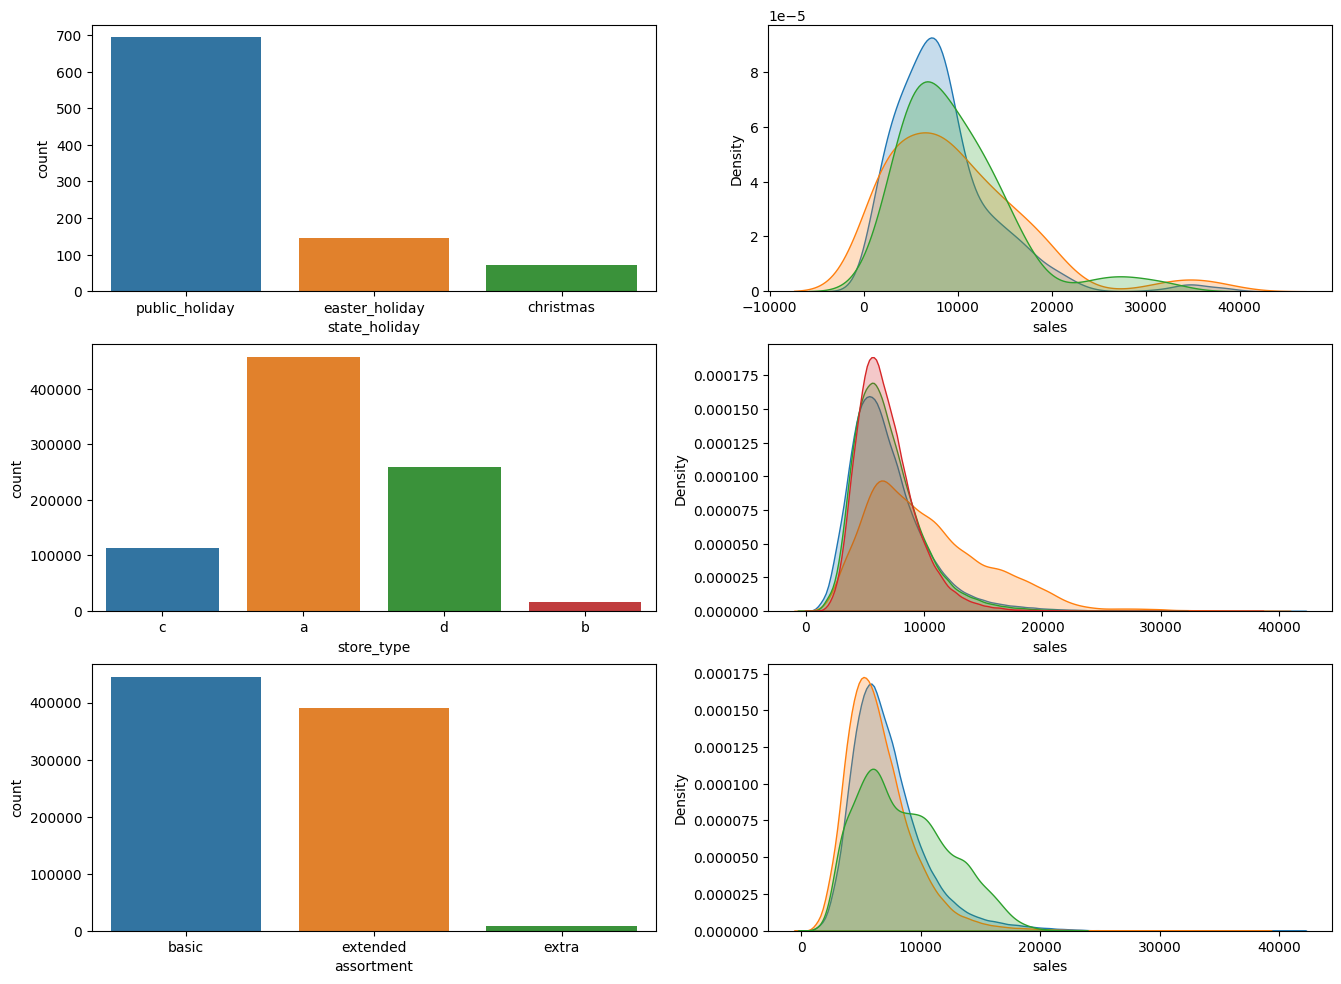

In [89]:
# state_holiday
plt.subplot( 3, 2, 1 )
aux1 = df4[df4['state_holiday'] != 'regular_day']
sb.countplot( aux1['state_holiday'] )

plt.subplot( 3, 2, 2 )
sb.kdeplot( data=df4[df4['state_holiday'] == 'public_holiday']['sales'], shade=True );
sb.kdeplot( data=df4[df4['state_holiday'] == 'easter_holiday']['sales'], shade=True );
sb.kdeplot( data=df4[df4['state_holiday'] == 'christmas']['sales'], shade=True );

# store_type
plt.subplot( 3, 2, 3 )
sb.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sb.kdeplot( data=df4[df4['store_type'] == 'a']['sales'], shade=True );
sb.kdeplot( data=df4[df4['store_type'] == 'b']['sales'], shade=True );
sb.kdeplot( data=df4[df4['store_type'] == 'c']['sales'], shade=True );
sb.kdeplot( data=df4[df4['store_type'] == 'd']['sales'], shade=True );

# assortment
plt.subplot( 3, 2, 5 )
sb.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sb.kdeplot( data=df4[df4['assortment'] == 'extended']['sales'], shade=True );
sb.kdeplot( data=df4[df4['assortment'] == 'basic']['sales'], shade=True );
sb.kdeplot( data=df4[df4['assortment'] == 'extra']['sales'], shade=True );

## 4.2. Bivariate Analysis

### **H5.** Lojas com maior sortimento de produtos deveriam vender mais.

**Falso**. De acordo com o gráfico abaixo, percebe-se que as lojas que possuem mais sortimento são as que vendem menos.

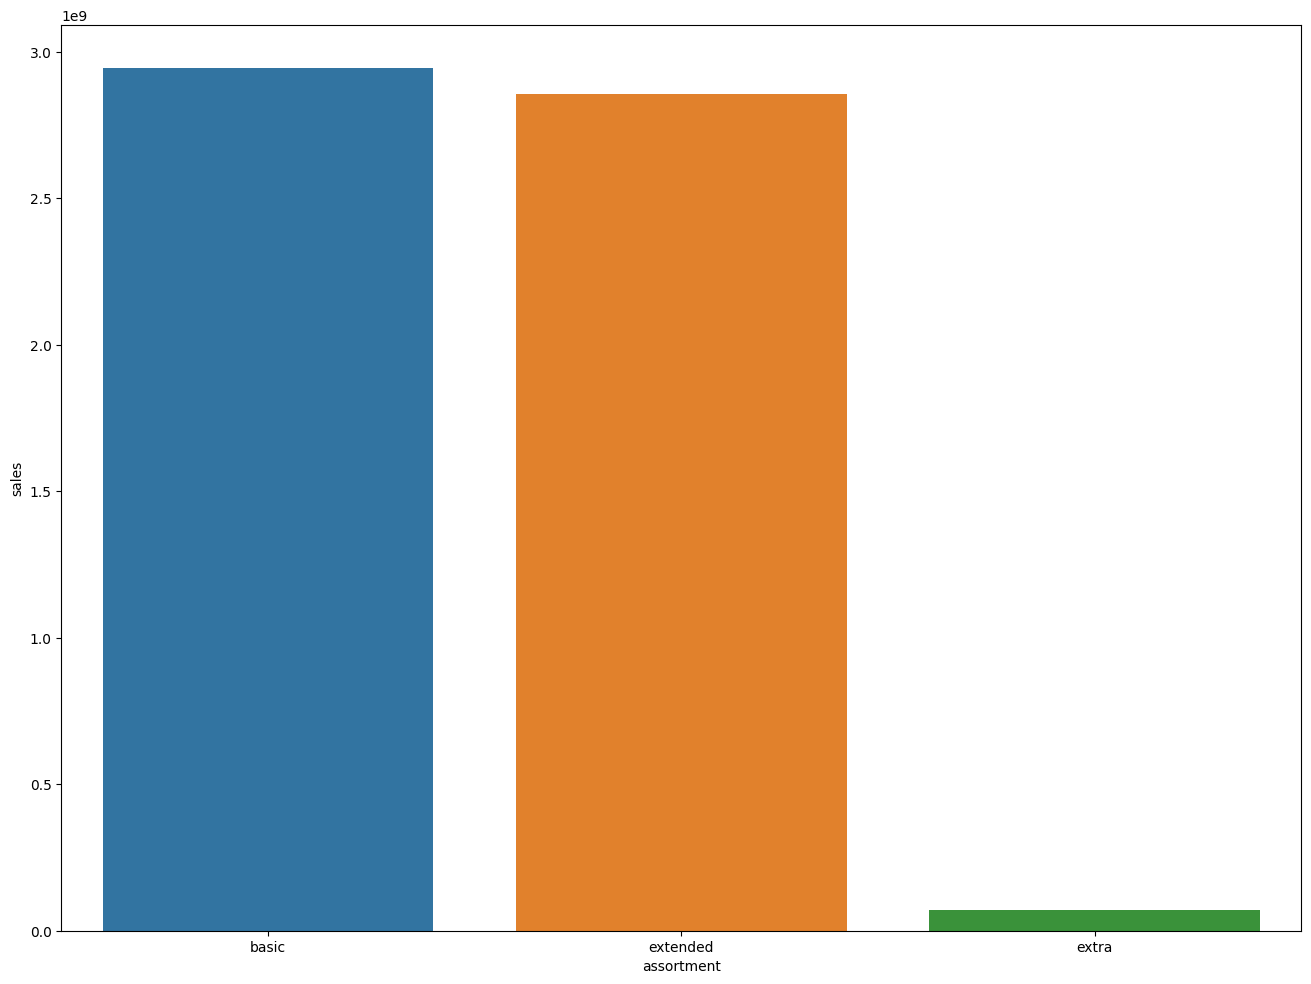

In [95]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sb.barplot( x='assortment', y='sales', data=aux1 );

Para fazer uma inspeção mais aprofundada desta hipótese, deseja-se inicialmente descobrir se as lojas com maior sortimento vendiam mais no passado do que atualmente. Mas, analisando o segundo gráfico temporal, percebe-se que o sortimento **extra** oscilou bastante durante o tempo, o que não era possível de ser identificado no primeiro gráfico. Analisando o primeiro gráfico, percebeu-se que os sortimentos **basic** e **extended** são muito similares, mas que visualizando o conjunto das 3 variáveis, elas serão relevantes para o modelo.

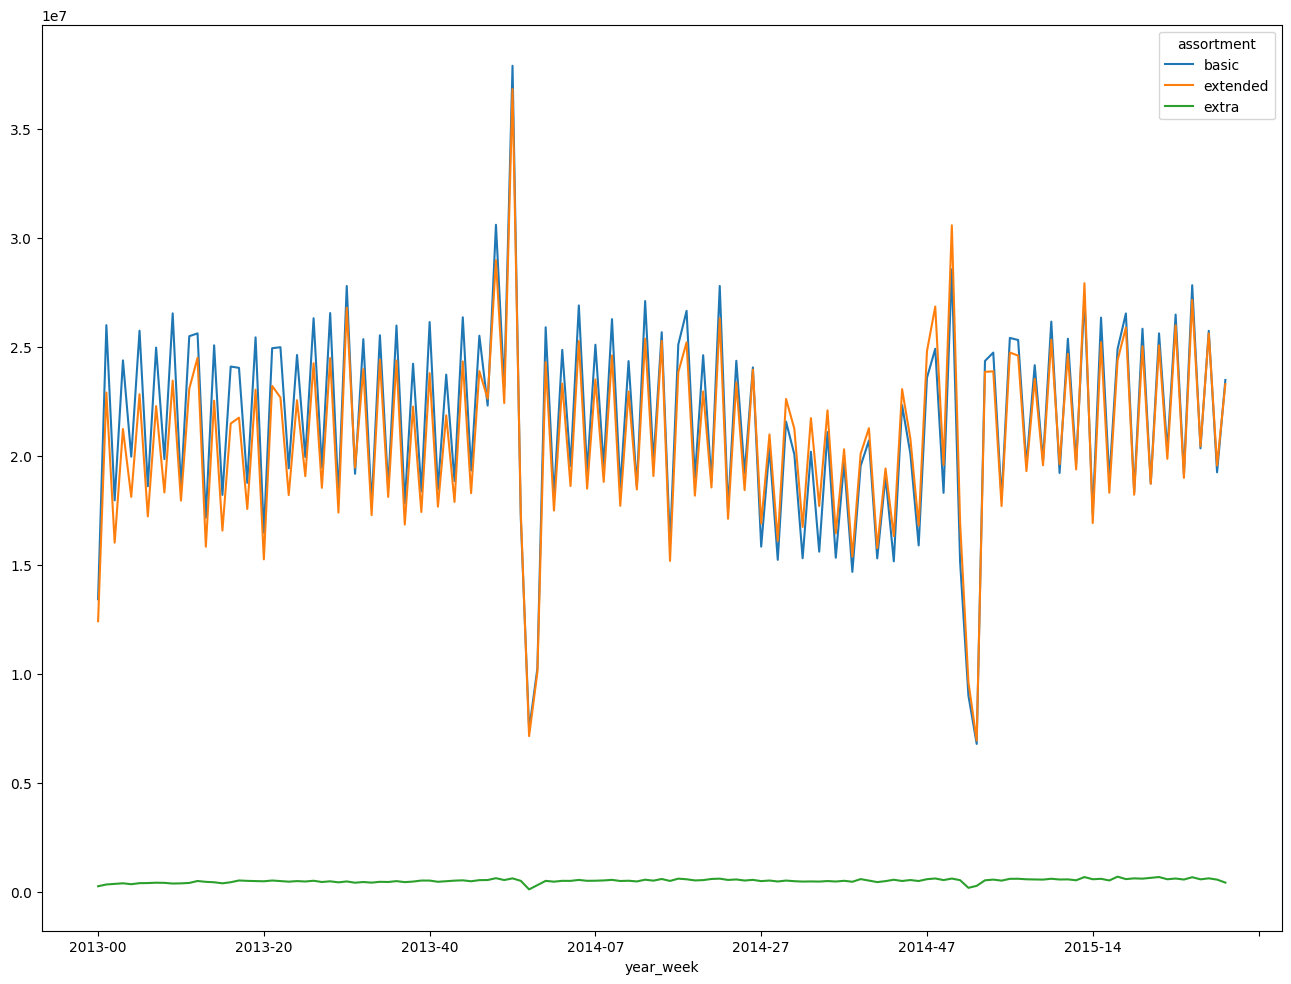

In [105]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();

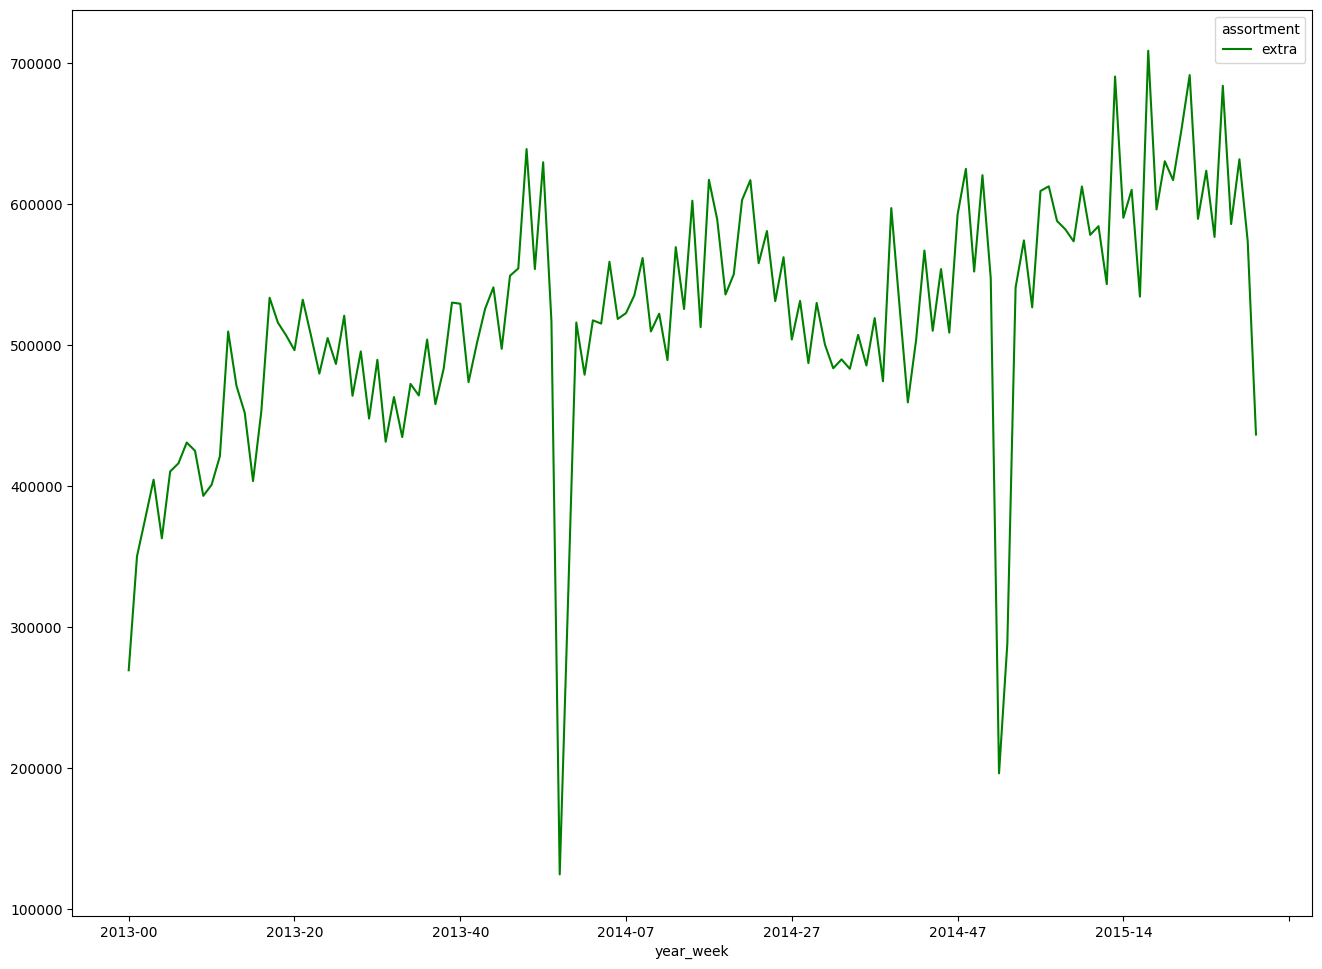

In [104]:
aux3 = df4[df4['assortment'] == 'extra']
aux3 = aux3[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot(color='green');

### **H6.** Lojas com competidores mais próximos deveriam vender menos.

**Falso**. Analisando os gráficos abaixo, percebe-se que as lojas que possuem competidores próximos vendem mais que as lojas que possuem competidores mais distantes. Oque é realmente intrigante, fugindo um pouco do censo comum de que "quanto maior a concorrência menor é a venda". Muito provável que este seja um insight relevante para o negócio.

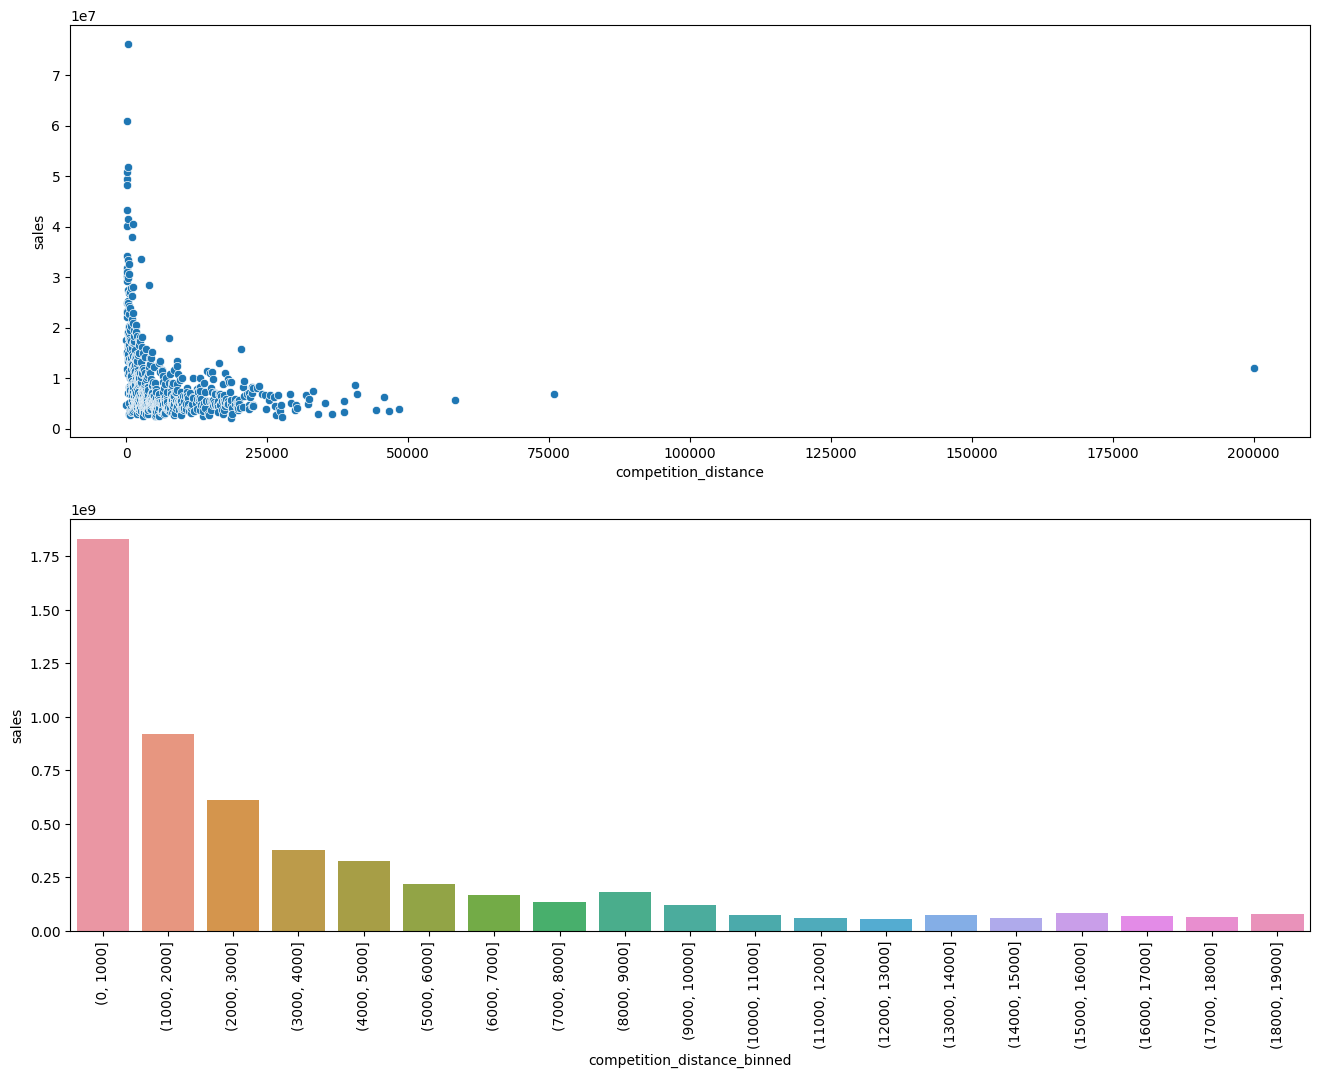

In [118]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

# agroup competition distance
bins = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()

# scatter plot
plt.subplot(2, 1, 1)
sb.scatterplot( x='competition_distance', y='sales', data=aux1 );

plt.subplot(2, 1, 2)
plt.xticks(rotation=90)
sb.barplot( x='competition_distance_binned', y='sales', data=aux2 );

Para inferir a correlação da feature com a variável resposta utilizou-se um heatmap. Na qual, percebe-se que esta variável sozinha possui uma certa correlação com as vendas.

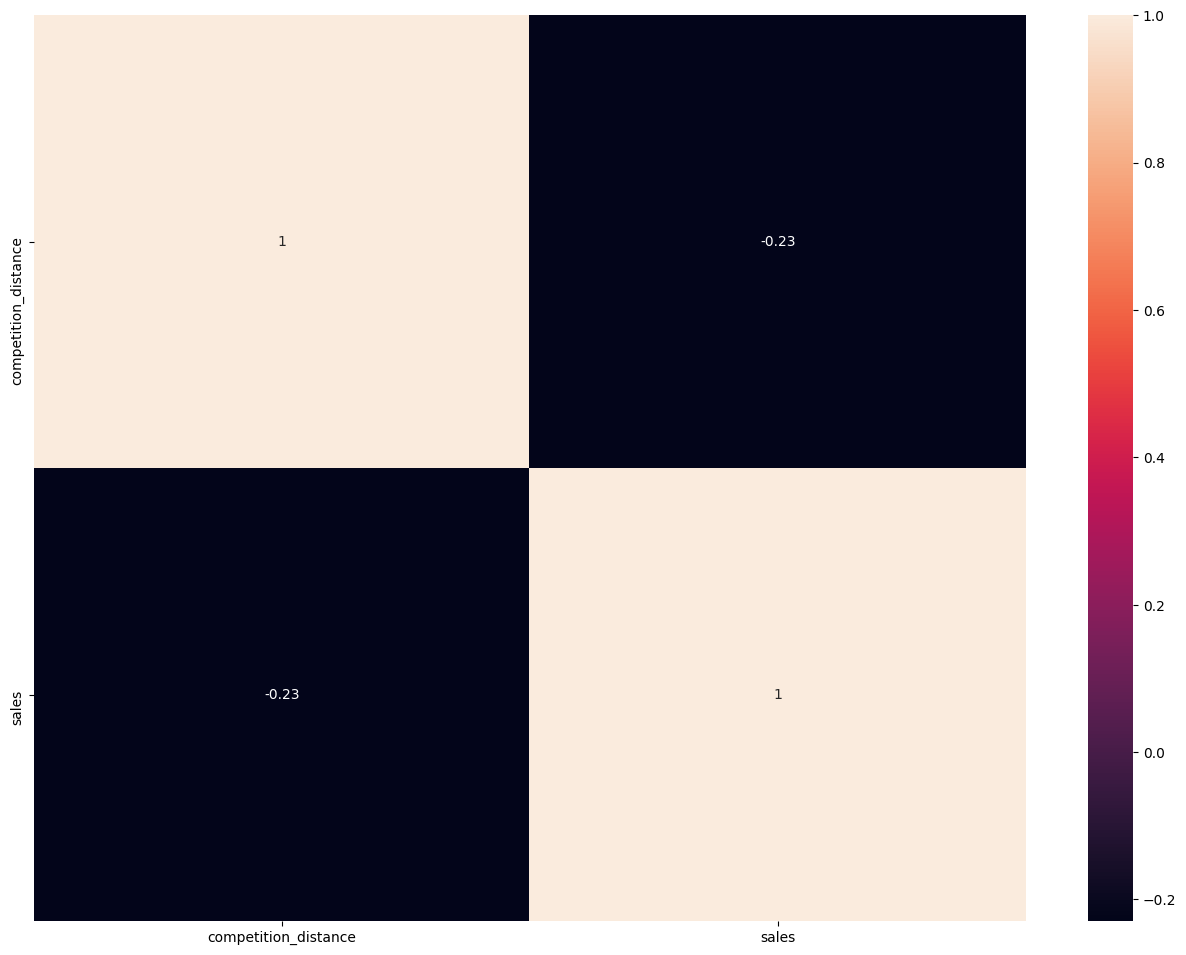

In [119]:
sb.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H7.** Lojas com competidores à mais tempo deveriam vender mais.

**Falso**. Analisando o gráfico abaixo, percebe-se que quanto mais recente é a concorrência, maior é o número de vendas, oque também é bastante intrigante. Portanto, lojas com competidores à mais tempo vendem menos.

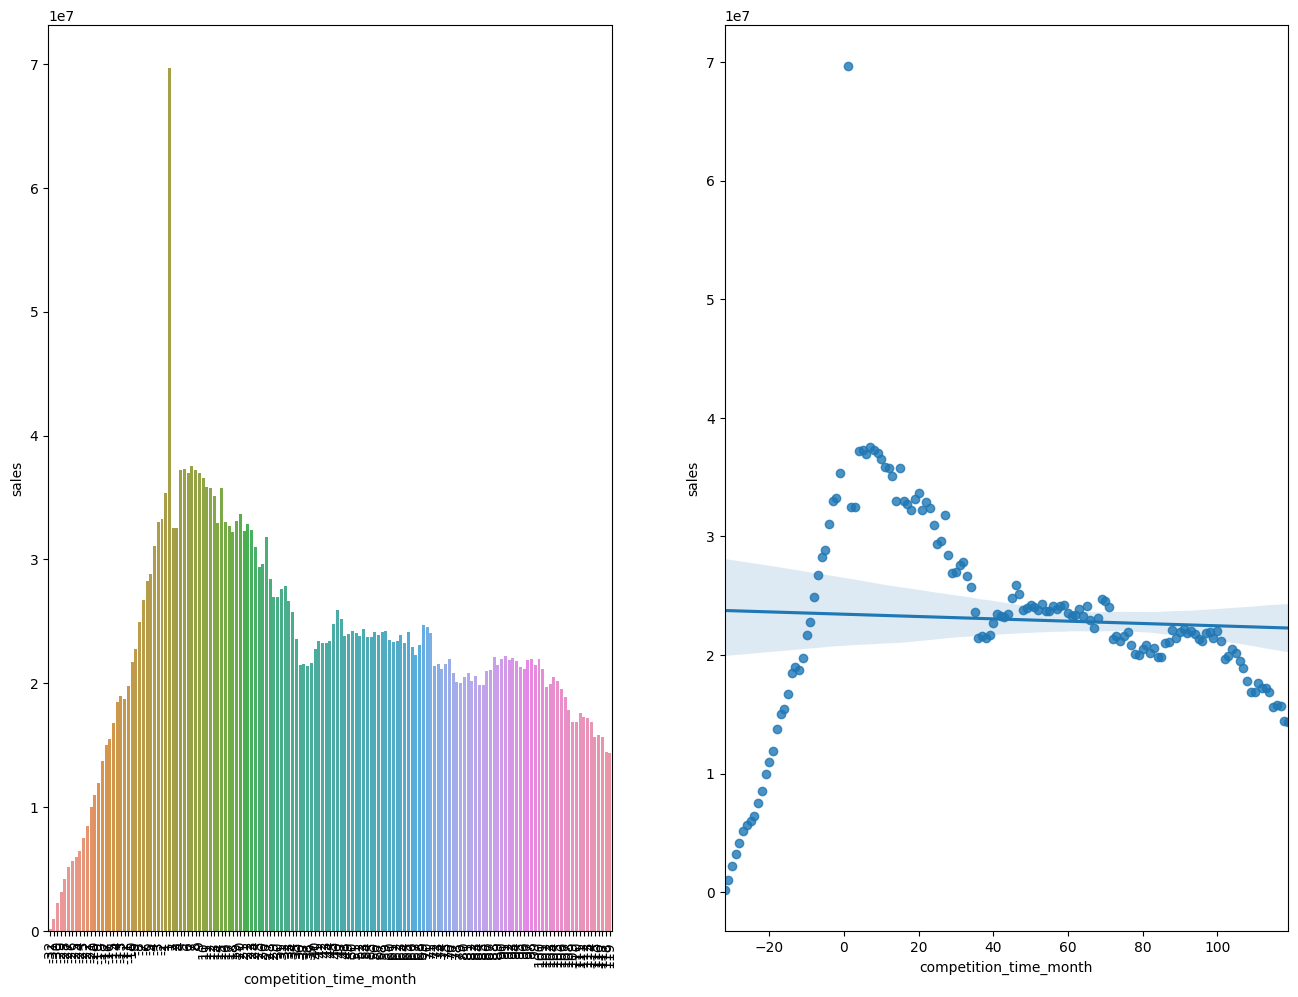

In [129]:
plt.subplot( 1 , 2, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
plt.xticks(rotation=90)
sb.barplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 2, 2 )
sb.regplot( x='competition_time_month', y='sales', data=aux2 );

Para inferir a correlação da feature com a variável resposta utilizou-se um heatmap. Na qual, percebe-se que esta variável sozinha possui uma correlação fraca com as vendas.

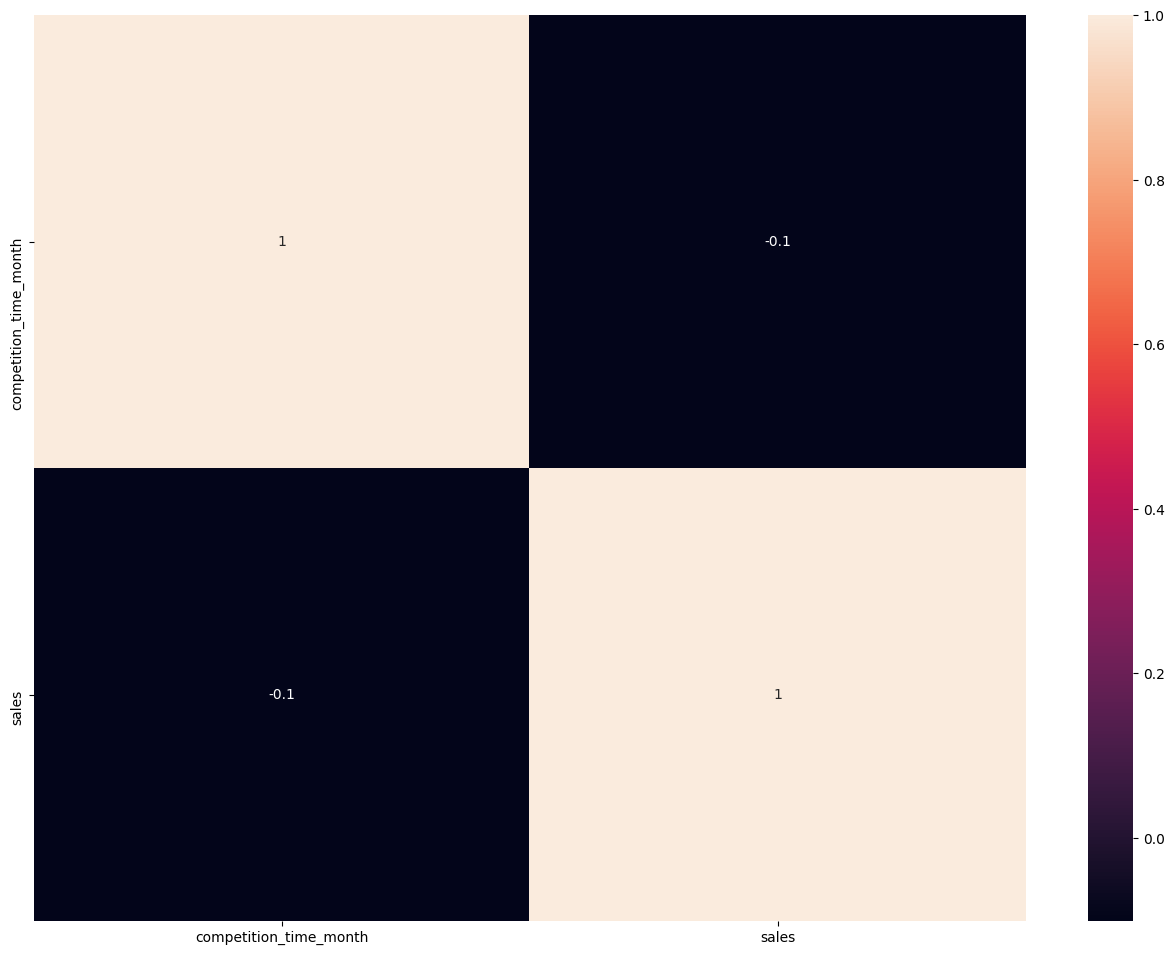

In [130]:
sb.heatmap( aux1.corr( method='pearson' ), annot=True );

## 4.3. Multivariate Analysis